In [1]:
import numpy as np
from itertools import product
from gurobipy import *
from json import loads
import matplotlib.pyplot as plt

In [2]:
class Distributions:
    """
    Represents a family of tail-truncated probability distributions.

    This class partitions a base distribution into multiple truncated versions,
    including a designated prior, and computes normalization constants and
    probability mass functions accordingly.

    Attributes:
        v (list of float): Support values of the base distribution.
        p (list of float): Probability masses corresponding to `v`.
        indices (list of int): Truncation indices for each distribution.
        cum_p_partition (list of float): Cumulative probabilities for each partition.
        v_partition (list of int): Maps each support value to its partition index.
        K (int): Total number of distributions.
        k_star (int): Index of the prior distribution in the sorted list of `indices`.
    """

    def __init__(self, probs, values = None, indices = None, prior_index = None):
        """
        Initializes the Distributions object with truncated probability distributions.
    
        Args:
            probs (list of float): Nonnegative probability masses corresponding to `values`.
            values (list of float): Strictly increasing nonnegative values representing the support. 
                                    If None, values is set to np.arange(1, len(probs)+1, 1).
            indices (list of int): Truncation indices for each distribution. If None, indices is set to list(range(len(values))).
            prior_index (int): Truncation index for the prior distribution. If None, prior_index is set to 0.
    
        Raises:
            ValueError: If any input fails validation checks.
        """        
        if not all(p >= 0 for p in probs):
            raise ValueError("All probs must be nonnegative.")

        if values is not None and not all(v >= 0 for v in values):
            raise ValueError("All values must be nonnegative.")
        if values is not None and not all(values[i] < values[i + 1] for i in range(len(values) - 1)):
            raise ValueError("Values must be strictly increasing.")
        if values is not None and len(probs) != len(values):
            raise ValueError("Values must have the same length as probs.")
        
        if indices is not None and not all(isinstance(index, int) and 0 <= index < len(probs) for index in indices):
            raise ValueError("Indices must be nonnegative integers between 0 and len(probs) - 1.")
        
        if prior_index is not None and not (isinstance(prior_index, int) and 0 <= prior_index < len(probs)):
            raise ValueError("Prior index must be an integer between 0 and len(probs) - 1.")

        sum_probs = sum(probs)
        probs = [_/sum_probs for _ in probs]
        self.p = probs
        if (values is None):
            self.v = np.arange(1, len(probs)+1, 1)
        else:
            self.v = values
        if (indices is None):
            self.indices = sorted(list(range(len(probs))), reverse=True)
        else:
            self.indices = sorted(set(indices+[prior_index]), reverse=True)
        self.K = len(self.indices)
        if (prior_index is None):
            self.k_star = 0
        else:
            self.k_star = self.indices.index(prior_index)
        self.v_partition = []
        p_partition = [0] * self.K
        l = 0
        for i in range(len(self.v)-1, -1, -1):
            if (l+1 <= len(self.indices)-1 and self.indices[l+1] == i):
                l += 1
            self.v_partition.insert(0,l)
            p_partition[l] += self.p[i]
        self.cum_p_partition = np.cumsum(p_partition[::-1])[::-1].tolist() + [0.0]

    def summarize(self, sigfig = 5):
        """
        Prints a summary of the distributions, including support and normalized PMFs.
    
        Args:
            sigfig (int): Number of significant figures to display.
        """
        print("Summary of distributions (*prior):")
        print(f"Support:\n    {[float(f'{v:.{sigfig}g}') for v in self.v]}")
        print("PMF:")
        for k in range(self.K):
            c_ = self.c(k)
            print(f"{'*' if k == self.k_star else ' '}{k}:", end=" ")
            print(
                [float(f'{p*c_:.{sigfig}g}')*(i <= self.indices[k])
                 for i, p in enumerate(self.p)]
            )
        print('\n')
            
    def I(self, x):
        """
        Returns the partition index for a given value or index.
    
        Args:
            x (int or list of int): Index or list of indices to evaluate.
    
        Returns:
            int: Partition index corresponding to `x`.
        """
        if (x is None):
            return self.K - 1
        if (type(x) == int):
            return self.v_partition[x]
        return self.v_partition[max(x)]

    def c(self, k):
        """
        Returns the normalization constant for distribution `k`.
    
        Args:
            k (int): Distribution index.
    
        Returns:
            float: Inverse of cumulative probability for partition `k`.
        """
        return 1/self.cum_p_partition[k]

    def P(self, t, l, mode):
        """
        Computes the probability of a sequence being in a given state under distribution `0`.
    
        Args:
            t (int): Sequence length.
            l (int): Partition index.
            mode (str): Either ">=" or "==", specifying the condition.
    
        Returns:
            float: Computed probability based on the mode.

            - If mode is ">=":
                Returns the probability that the largest of `t` elements 
                fall within partition `l` or higher.

            - If mode is "==":
                Returns the probability that the largest of `t` elements 
                fall exactly within partition `l`.

            - If `t == 0`:
                - For ">=": Always returns 1 (empty sequence is trivially valid).
                - For "==": Returns 1 if `l` is the last partition (`K - 1`), else 0.
    
        Raises:
            ValueError: If `mode` is not recognized.
        """
        if (mode == ">="):
            if (t == 0):
                return 1
            return self.cum_p_partition[l]**t
        if (mode == "=="):
            if (t == 0):
                return (1 if l == self.K-1 else 0)
            return self.cum_p_partition[l]**t - self.cum_p_partition[l+1]**t

In [3]:
class LP_maxprob:
    """
    Constructs and solves a linear programming model to optimize consistency and robustness 
    in a sequence of truncated probability distributions using Gurobi.

    This model evaluates the trade-off between two metrics—alpha (consistency) and beta (robustness)— 
    based on a given family of truncated distributions and sequence length.

    Attributes:
        n (int): Length of the arrival sequence.
        F (Distributions): Instance of the Distributions class representing the truncated distributions.
        model (gurobipy.Model): Gurobi optimization model.
        alpha (float or None): Consistency parameter (or `None` if optimized).
        beta (float or None): Robustness parameter (or `None` if optimized).
        S (gurobipy.VarDict): Decision variables representing survival probabilities.
    """
    
    def __init__(self, n, F, alpha, beta, outputflag = 0, monotone = False):
        """
        Initializes the LP model and builds the optimization problem.
    
        Args:
            n (int): Length of the arrival sequence.
            F (Distributions): Instance of the Distributions class.
            alpha (float or None): Consistency requirement. Must be None if beta is provided.
            beta (float or None): Robustness requirement. Must be None if alpha is provided.
            outputflag (int): 0 to suppress solver output, 1 to enable it.
    
        Raises:
            ValueError: If `n` is not a positive integer.
        """
        if not (isinstance(n, int) and n > 0):
            raise ValueError("n must be a positive integer.")
        if not ((alpha is None and isinstance(beta, (float,int)) and 0 <= beta <= 1) or 
                (isinstance(alpha, (float,int)) and 0 <= alpha <= 1 and beta is None)):
            raise ValueError("Exactly one of alpha and beta must be None. The other one must be a float or int between 0 and 1.")
        self.n = n
        self.F = F
        self.model = Model()
        self.build(alpha, beta, outputflag)

    def build(self, alpha, beta, outputflag = 0):
        """
        Constructs the LP model by defining variables, objective, and constraints.
        
        Args:
            alpha (float or None): Consistency requirement.
            beta (float or None): Robustness requirement.
            outputflag (int): Gurobi output flag.
        
        Raises:
            ValueError: If both alpha and beta are provided or both are None.
        """
        self.model.setParam('OutputFlag', outputflag)
        self.model.setParam('MIPGap', 1e-9)

        # Add decision variables S[t, l] ∈ [0, 1]
        self.S = self.model.addVars(list(product(range(self.n+1), range(self.F.K))), lb=0, ub=1, name="S")

        # Define objective variable and set optimization direction
        if (beta is None):
            self.alpha = float(alpha)
            self.beta = self.model.addVar(name="beta", lb=0, ub=1)
            self.model.setObjective(self.beta, GRB.MAXIMIZE)
            print(f"Given alpha = {self.alpha}, maximizing beta ...")
        else:
            self.alpha = self.model.addVar(name="alpha", lb=0, ub=1)
            self.beta = float(beta)
            self.model.setObjective(self.alpha, GRB.MAXIMIZE)
            print(f"Given beta = {self.beta}, maximizing alpha ...")

        # Add consistency constraint for the prior distribution
        self.model.addConstr(self.alpha <= self.ALG(self.F.k_star, self.S), name=f"consistency_{self.F.k_star}")

        # Add robustness constraint for the prior distribution
        for k in self.F.indices:
            self.model.addConstr(self.beta <= self.ALG(k, self.S), name=f"robustness_{k}")

        # Add constraints related to survival and stopping probabilities
        for t in range(self.n+1):
            for l in range(self.F.K):
                if (t == 0): # initial condition for survival probabilities
                    self.model.addConstr(self.S[t,l] == (1 if l == self.F.K-1 else 0), name=f"Exact_{(t,l)}")
                elif (t > 1): # constraints for stopping probabilities
                    self.model.addConstr(
                        self.S[t,l] * self.F.P(t,l,"==") - self.S[t-1,l] * self.F.P(t-1,l,"==") * self.F.P(1,l+1,">=") >= 0, 
                        name=f"R_{(t,l)} <= 1"
                    )
                    self.model.addConstr(
                        self.S[t,l] * self.F.P(t,l,"==") - self.S[t-1,l] * self.F.P(t-1,l,"==") * self.F.P(1,l+1,">=") 
                        <= self.F.P(1,l,"==") * sum(self.S[t-1,m] * self.F.P(t-1,m,"==") for m in range(l, self.F.K)),
                        name=f"R_{(t,l)} >= 0"
                    )
                    
    def ALG(self, k, S):
        """
        Computes the winning probability for distribution `k`.

        The return type depends on the type of `S`:
        - If `S` is a Gurobi VarDict, returns a symbolic linear expression (`gurobipy.LinExpr`)
        - If `S` is a plain dictionary of floats, returns a numerical value (`float`)
    
        Args:
            k (int): Index of the distribution.
            S (dict or gurobipy.VarDict): Dictionary of decision variables representing survival probabilities.
    
        Returns:
            float or gurobipy.LinExpr: Winning probability or its linear expression.
        """
        c = self.F.c(k)
        return c**(self.n) * sum(
            sum(self.F.P(self.n-t,l,">=") * (
                sum(S[t-1,m] * self.F.P(t-1,m,"==") for m in range(l, self.F.K)) * self.F.P(1,l,"==")
                + S[t-1,l] * self.F.P(t-1,l,"==") * self.F.P(1,l+1,">=") - S[t,l] * self.F.P(t,l,"==")
            )
            for l in range(k, self.F.K)
                )
            for t in range(1, self.n+1)
            )
    
        
    def recover_rule(self, S):
        """
        Recovers the stopping rule from the optimized survival probabilities.
    
        Args:
            S (dict): Dictionary of optimized survival probabilities.
    
        Returns:
            dict: Mapping from (t, l) to stopping probabilities.
        """
        R = {}
        for t in range(1, self.n+1):
            for l in range(self.F.K):
                if (t == 1):
                    R[t,l] = 1 - S[t,l]
                elif (self.F.P(1,l,"==") * sum(S[t-1,m] * self.F.P(t-1,m,"==") for m in range(l, self.F.K)) > 0):
                    R[t,l] = 1 - (
                        S[t,l] * self.F.P(t,l,"==") - S[t-1,l] * self.F.P(t-1,l,"==") * self.F.P(1,l+1,">=")
                        )/(
                            self.F.P(1,l,"==") * sum(S[t-1,m] * self.F.P(t-1,m,"==") for m in range(l, self.F.K))
                        )
                else:
                    R[t,l] = None
        return R
    
    def solve(self):
        """
        Solves the LP model using Gurobi and extracts the optimized values.
    
        Returns:
            tuple:
                - S (dict): Optimized state probabilities.
                - alpha (float): Optimized or fixed consistency value.
                - beta (float): Optimized or fixed robustness value.
    
        Prints:
            Status messages and final optimized values.
    
        Returns:
            (dict, float, float): If successful.
            (None, None, None): If optimization fails or model is infeasible.
        """
        self.model.optimize()  
        status = self.model.status
        if status == GRB.OPTIMAL:
            S = {}
            for x in self.model.getVars():
                if (x.VarName.startswith('S')):
                    name = tuple(loads(x.VarName[1:]))
                    S[name] = x.X
                elif (x.VarName == 'alpha'):
                    alpha = x.X
                    beta = self.beta
                    print(f"Optimal solution found, alpha * = {alpha}")
                elif (x.VarName == 'beta'):
                    beta = x.X
                    alpha = self.alpha
                    print(f"Optimal solution found, beta * = {beta}")
            return S, alpha, beta
        elif status == GRB.INF_OR_UNBD:
            print("Model is infeasible or unbounded.")
        elif status == GRB.TIME_LIMIT:
            print("Time limit reached.")
        elif status == GRB.INTERRUPTED:
            print("Optimization was interrupted.")
        elif status == GRB.UNBOUNDED:
            print("Model is unbounded.")
        elif status == GRB.INFEASIBLE:
            print("Model is infeasible.")
        else:
            print("Optimization was not successful. Status code:", status)
        return None, None, None

In [4]:
def experiment(n, p, density):
    """
    Runs a parametric experiment to evaluate the trade-off between consistency (alpha) 
    and robustness (beta) in a truncated distribution model.

    This function initializes a distribution and solves a linear programming model 
    for a fixed robustness level (`beta = 0`). It then iteratively varies the consistency 
    parameter `alpha` from a lower bound (0.58) to the maximum feasible value, solving 
    the model at each step and recording the resulting beta values. Only successful 
    solutions are retained and plotted.

    Args:
        n (int): Length of the arrival sequence.
        p (list of float): Probability mass function for the base distribution.
        density (float): Step size for sampling alpha values between 0.58 and the maximum feasible alpha.

    Returns:
        tuple:
            - Alpha_ (list of float): List of alpha values for which the model was successfully solved.
            - Beta_ (list of float): Corresponding beta values from the solved models.
    """
    F = Distributions(p)
    model = LP_maxprob(n, F, alpha = None, beta = 0, outputflag = 0)
    _, max_alpha, _ = model.solve()
    Alpha = np.linspace(np.exp(-1), max_alpha, int((max_alpha - np.exp(-1))/density)+2)
    Beta = []
    solved_set = []
    beta = None
    for alpha_id, alpha in enumerate(Alpha):
        model = LP_maxprob(n, F, alpha, beta, outputflag = 0)
        S, a, b = model.solve()
        Beta.append(b)
        if S is not None:
            solved_set.append(alpha_id)
    Alpha_ = [alpha for i, alpha in enumerate(Alpha) if i in solved_set]
    Beta_ = [beta for i, beta in enumerate(Beta) if i in solved_set]
    return Alpha_, Beta_

In [5]:
n = 4   # number of arrivals
m = 6   # support size
print(f"n = {n}, m = {m}")
p = [1/i for i in range(1, m+1)]   # relative probability masses (in ascending order of corresponding value)
F = Distributions(p)
F.summarize()

n = 4, m = 6
Summary of distributions (*prior):
Support:
    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
PMF:
*0: [0.40816, 0.20408, 0.13605, 0.10204, 0.081633, 0.068027]
 1: [0.43796, 0.21898, 0.14599, 0.10949, 0.087591, 0.0]
 2: [0.48, 0.24, 0.16, 0.12, 0.0, 0.0]
 3: [0.54545, 0.27273, 0.18182, 0.0, 0.0, 0.0]
 4: [0.66667, 0.33333, 0.0, 0.0, 0.0, 0.0]
 5: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]




In [6]:
alpha, beta = 0.751, None     # Try another combination for different result: alpha, beta = None, 0.7
model = LP_maxprob(n, F, alpha, beta, outputflag = 0)
S, alpha, beta = model.solve()
print("Winning probability for distributions:")
if S is not None:
    for k in range(model.F.K):
        print(f"{'*' if k == model.F.k_star else ' '}{k}: {model.ALG(k, S)}")
        
    print("\nOptimal survival probabilities:")
    for key, value in S.items():
        print(f"S{key}, {value}")
    
    R = model.recover_rule(S)
    print("\nOptimal stopping probabilities:")
    for key, value in R.items():
        print(f"R{key}, {value}")

Set parameter Username
Set parameter LicenseID to value 2699121
Academic license - for non-commercial use only - expires 2026-08-24
Given alpha = 0.751, maximizing beta ...
Optimal solution found, beta * = 0.6815609473770903
Winning probability for distributions:
*0: 0.751
 1: 0.768992283204936
 2: 0.7680847450967678
 3: 0.6815609473770903
 4: 0.7530864197530865
 5: 1.0

Optimal survival probabilities:
S(0, 0), 0.0
S(0, 1), 0.0
S(0, 2), 0.0
S(0, 3), 0.0
S(0, 4), 0.0
S(0, 5), 1.0
S(1, 0), 0.0
S(1, 1), 0.0
S(1, 2), 0.0
S(1, 3), 1.0
S(1, 4), 1.0
S(1, 5), 1.0
S(2, 0), 0.0
S(2, 1), 0.0
S(2, 2), 0.0
S(2, 3), 0.7889710399543265
S(2, 4), 1.0
S(2, 5), 1.0
S(3, 0), 0.0
S(3, 1), 0.0
S(3, 2), 0.0
S(3, 3), 0.47180992422517853
S(3, 4), 0.5263157894736842
S(3, 5), 1.0
S(4, 0), 0.0
S(4, 1), 0.0
S(4, 2), 0.0
S(4, 3), 0.3163695754272299
S(4, 4), 0.30769230769230765
S(4, 5), 0.0

Optimal stopping probabilities:
R(1, 0), 1.0
R(1, 1), 1.0
R(1, 2), 1.0
R(1, 3), 0.0
R(1, 4), 0.0
R(1, 5), 0.0
R(2, 0), 1.0
R(2

n = 24, m = 200
Given beta = 0.0, maximizing alpha ...
Optimal solution found, alpha * = 0.5961701228601995
Given alpha = 0.36787944117144233, maximizing beta ...
Optimal solution found, beta * = 0.4364345557718826
Given alpha = 0.39070850934031803, maximizing beta ...
Optimal solution found, beta * = 0.4364345557718826
Given alpha = 0.4135375775091938, maximizing beta ...
Optimal solution found, beta * = 0.4364345557718826
Given alpha = 0.4363666456780695, maximizing beta ...
Optimal solution found, beta * = 0.4364345557718826
Given alpha = 0.45919571384694524, maximizing beta ...
Optimal solution found, beta * = 0.43324473270837643
Given alpha = 0.48202478201582094, maximizing beta ...
Optimal solution found, beta * = 0.4289866070997483
Given alpha = 0.5048538501846966, maximizing beta ...
Optimal solution found, beta * = 0.4230660238251212
Given alpha = 0.5276829183535724, maximizing beta ...
Optimal solution found, beta * = 0.4142708936627217
Given alpha = 0.5505119865224481, maxim

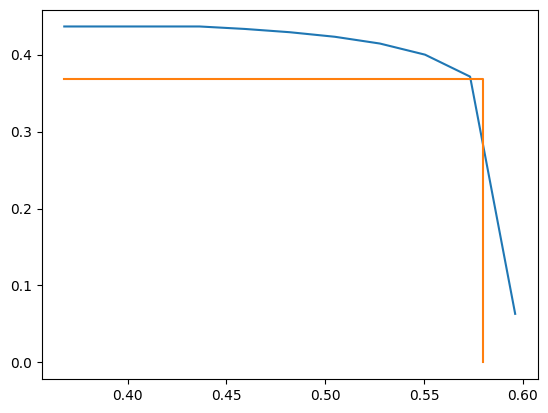

In [7]:
n = 24   # number of arrivals
m = 200   # support size
print(f"n = {n}, m = {m}")
p = [1/i for i in range(1, m+1)]   # relative probability masses (in ascending order of corresponding value)
density = 0.025
Alpha, Beta = experiment(n, p, density)
plt.plot(Alpha, Beta)
plt.plot([0.58, 0.58, np.exp(-1)], [0, np.exp(-1), np.exp(-1)], '-')
plt.show()